In [94]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import time
import os
from IPython.core.debugger import set_trace
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats



In [96]:
df=pd.read_csv('/content/Netflix Stock.csv',index_col='Date')

In [97]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998605,0.998508,0.996812,0.996812,-0.415838
High,0.998605,1.000000,0.998203,0.998551,0.998551,-0.400699
Low,0.998508,0.998203,1.000000,0.998544,0.998544,-0.432116
Close,0.996812,0.998551,0.998544,1.000000,1.000000,-0.413362
Adj Close,0.996812,0.998551,0.998544,1.000000,1.000000,-0.413362
Volume,-0.415838,-0.400699,-0.432116,-0.413362,-0.413362,1.000000


<Axes: xlabel='Date'>

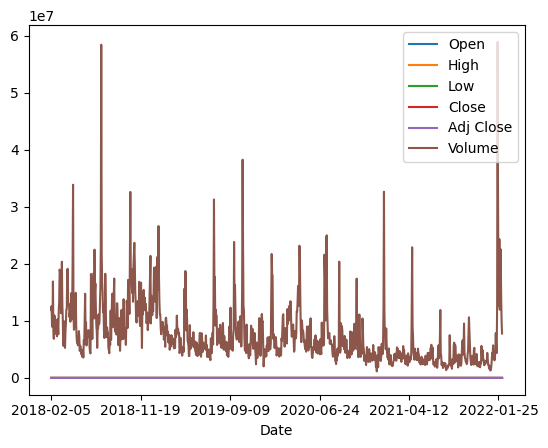

In [98]:
df.plot()

In [99]:
#checking datatypes for features
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [100]:
#Transofrming the Date Index Column into a date_time format
df.index=pd.to_datetime(df.index)
df.index.month

Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       ...
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
      dtype='int32', name='Date', length=1009)

In [101]:
#Checking for missing values:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

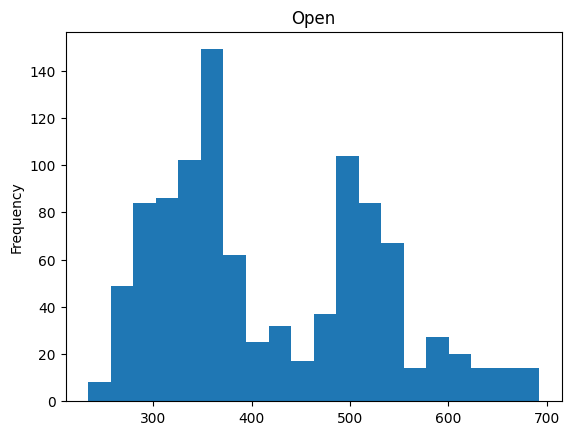

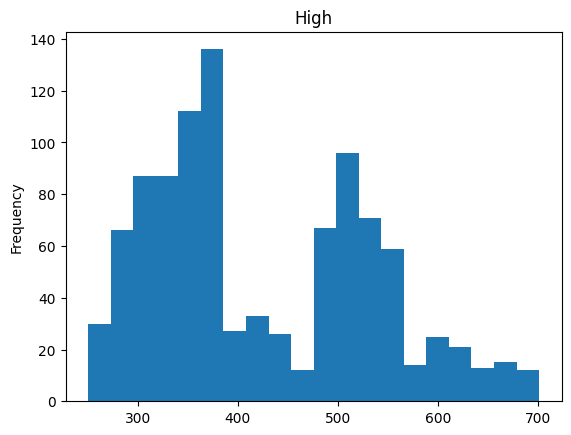

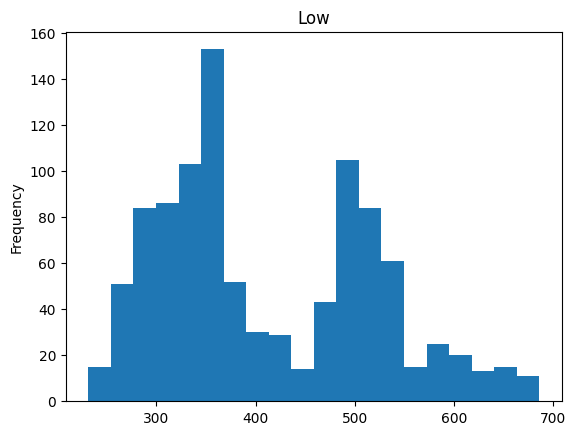

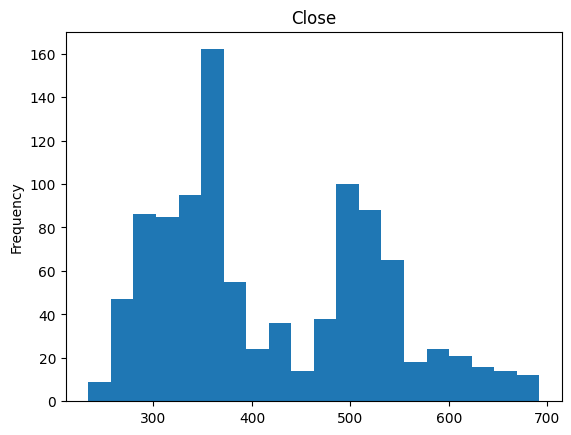

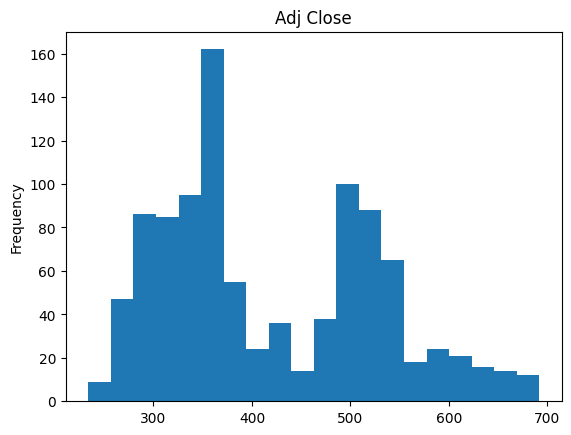

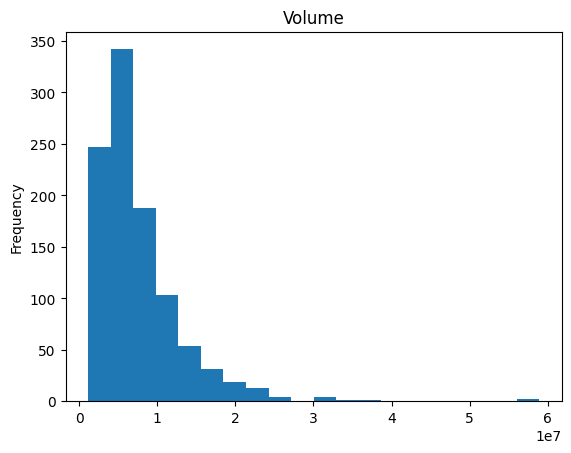

In [102]:
#Plotting the features using a histogram
for i in df.columns:
  df[i].plot(kind='hist', bins=20, title=i)
  plt.show()

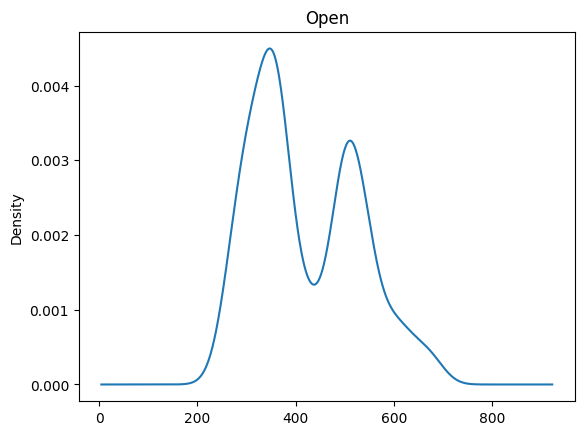

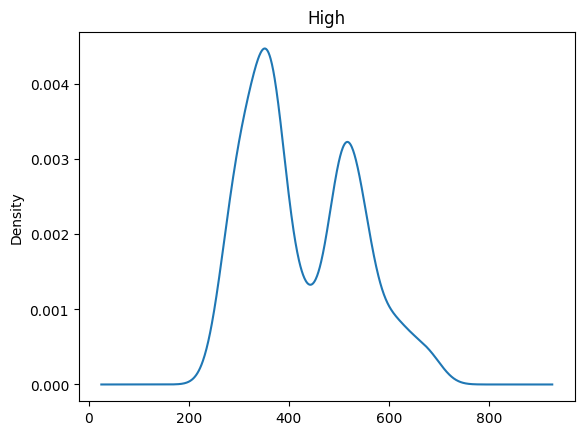

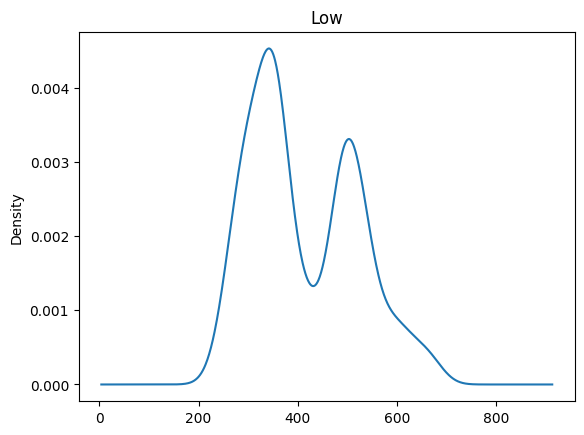

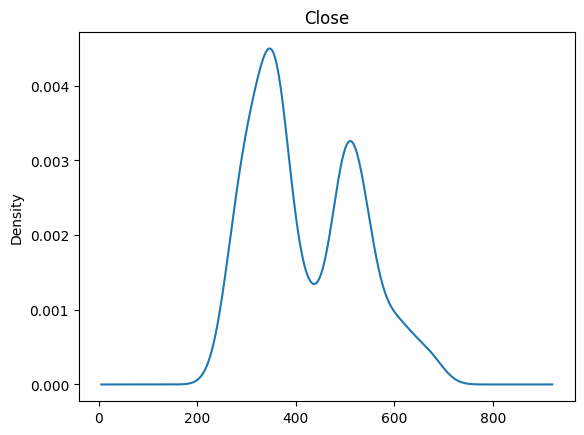

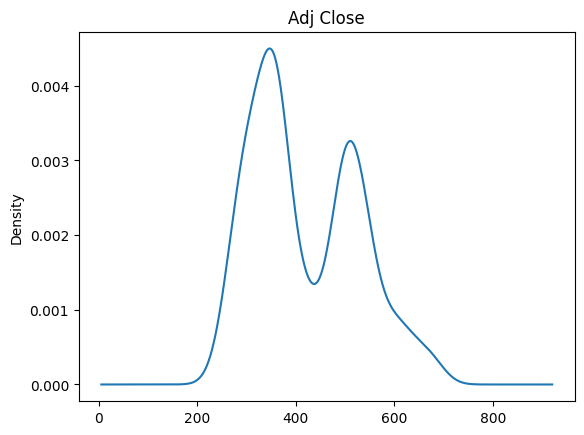

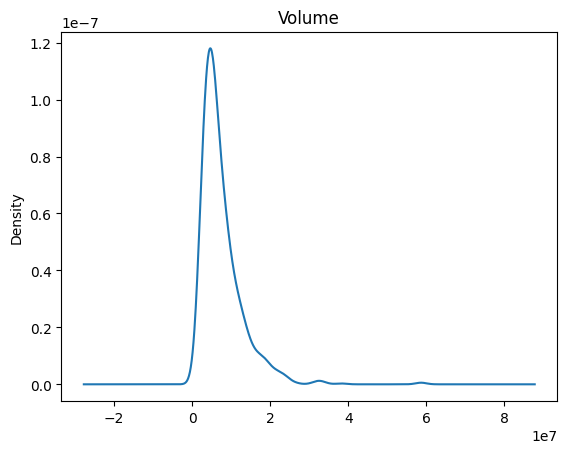

In [103]:
#Plotting the features using a Kernel Density
for i in df.columns:
  df[i].plot(kind='kde', title=i)
  plt.show()

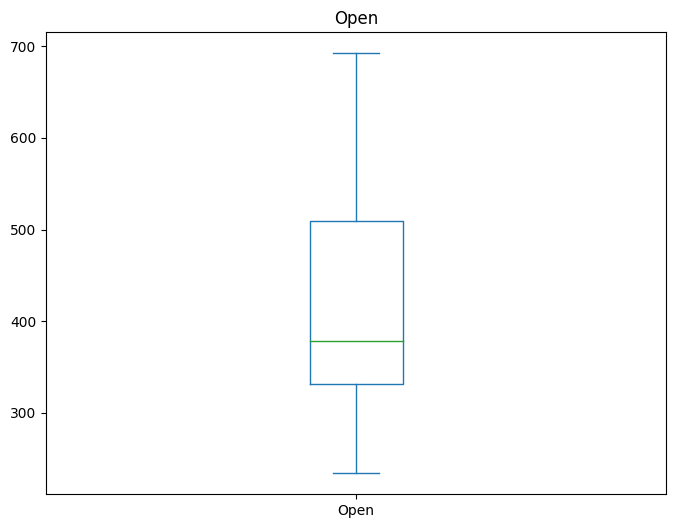

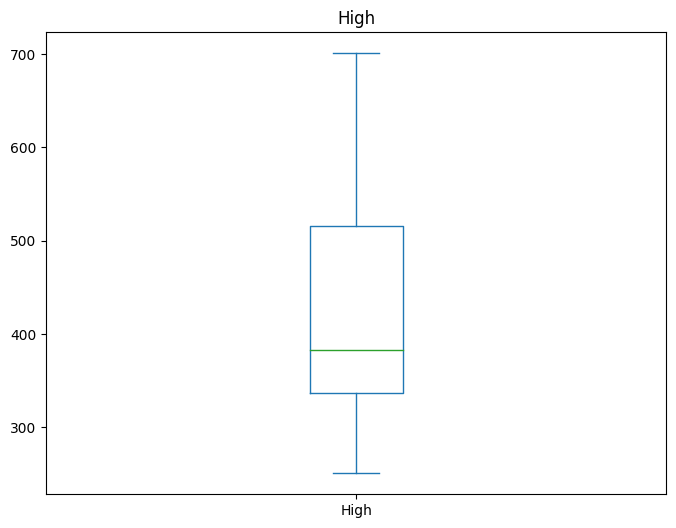

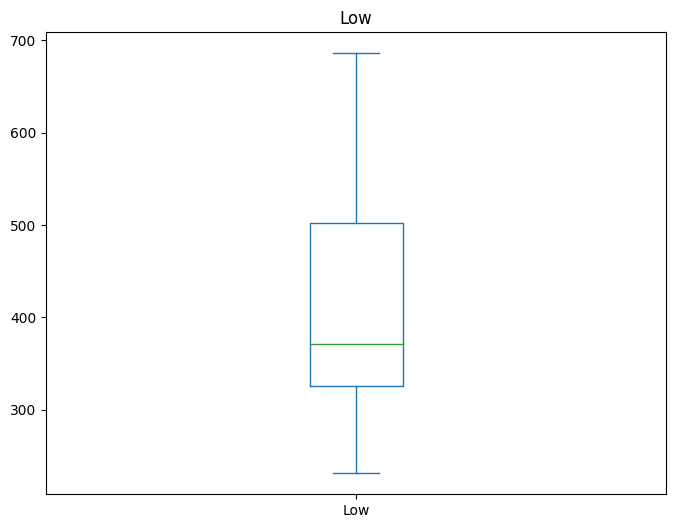

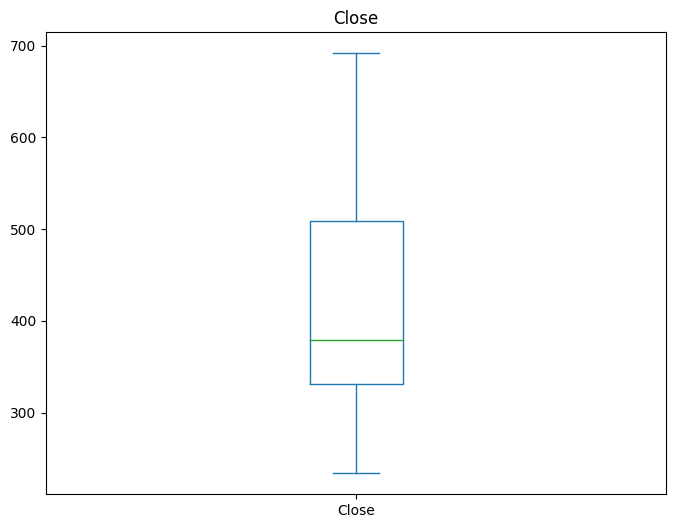

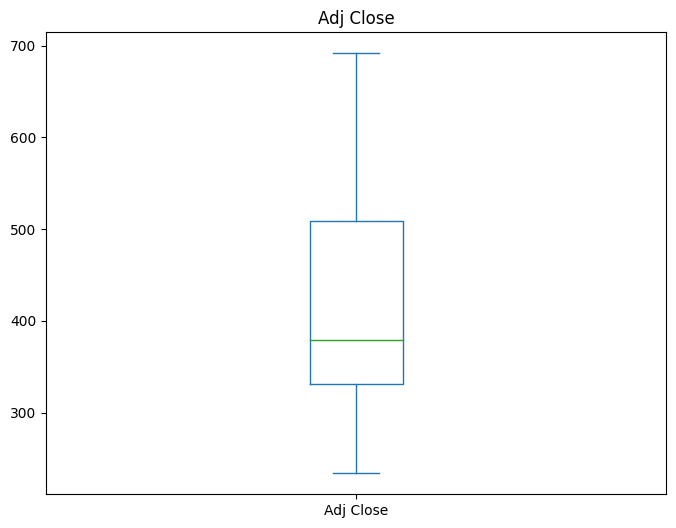

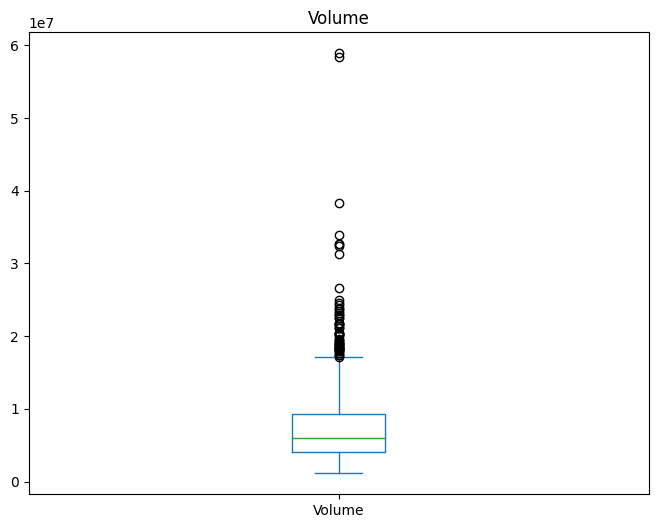

In [104]:
#Plotting the features using boxplot to detect outliers
for i in df.columns:
  df[i].plot(kind='box', figsize=(8,6), title=i)
  plt.show()

<Axes: title={'center': 'Volume'}>

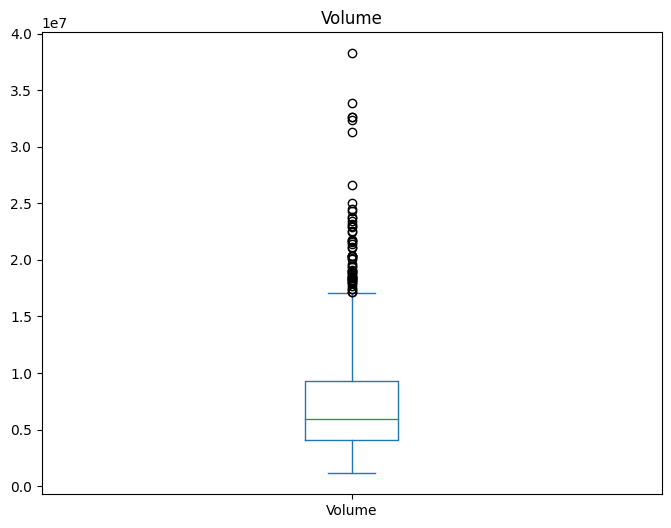

In [105]:
# #Outlier removal from volume
df['Volume'].tail(10)
df=df[df['Volume']<45000000]
df['Volume'].plot(kind='box', figsize=(8,6), title='Volume')

In [106]:
#Showing Correlation
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998648,0.998516,0.996856,0.996856,-0.449046
High,0.998648,1.000000,0.998249,0.998552,0.998552,-0.435567
Low,0.998516,0.998249,1.000000,0.998585,0.998585,-0.465925
Close,0.996856,0.998552,0.998585,1.000000,1.000000,-0.449024
Adj Close,0.996856,0.998552,0.998585,1.000000,1.000000,-0.449024
Volume,-0.449046,-0.435567,-0.465925,-0.449024,-0.449024,1.000000


In [107]:
#Removing highly Correlated Feature
df = df.drop('Adj Close', axis=1)

In [108]:
#Creating Window Features:
#Adding rolling mean
df['month_Close'] = df['Close'].rolling(30).mean()
warnings.filterwarnings('ignore')

In [109]:
#Measuring how different the closing price is on a given day from the monthly average
df['month_day_Close'] = df['month_Close'] / df['Close']
warnings.filterwarnings('ignore')

In [110]:
#Measuring the ratio between the Close and Open prices
df['Close_Open']=df['Close'] / df['Open']
warnings.filterwarnings('ignore')

Accuracy: 0.9983582868103333,  MSE: 8.054415004856224, RMSE: 2.8380301275455526, MAE: 2.0082274641198907


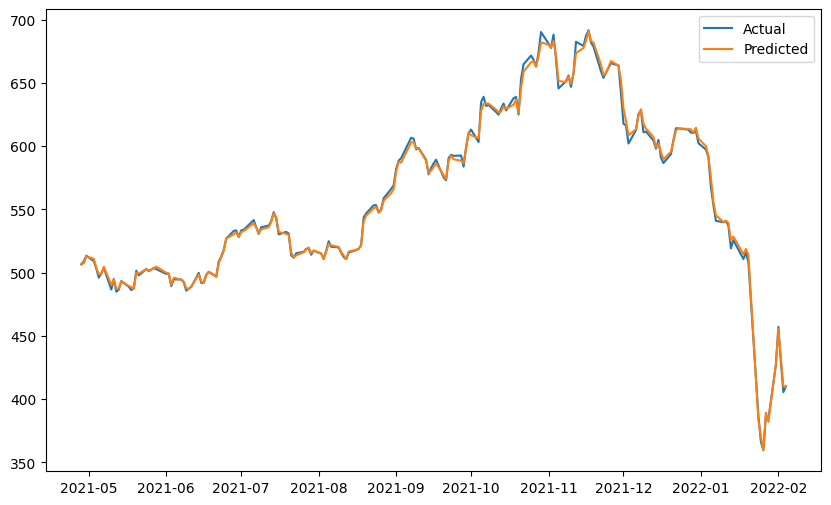

In [111]:
# Create lag features
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Drop rows with missing values created due to some window features
df.dropna(inplace=True)

# Prepare features and target
features = df[['Open', 'High', 'Low', 'Volume', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3','month_Close', 'month_day_Close', 'Close_Open']]
target = df['Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

#Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model=linear_model.Ridge(alpha=0.5)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy},  MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [112]:
df.corr()['Close']

Open               0.996792
High               0.998510
Low                0.998562
Close              1.000000
Volume            -0.440933
month_Close        0.959937
month_day_Close   -0.183893
Close_Open         0.020319
Close_Lag1         0.994525
Close_Lag2         0.989505
Close_Lag3         0.984435
Name: Close, dtype: float64

Accuracy: 0.6193724620060854, MSE: 43.21340229439883, RMSE: 2.8380301275455526, MAE: 26.23356408769425


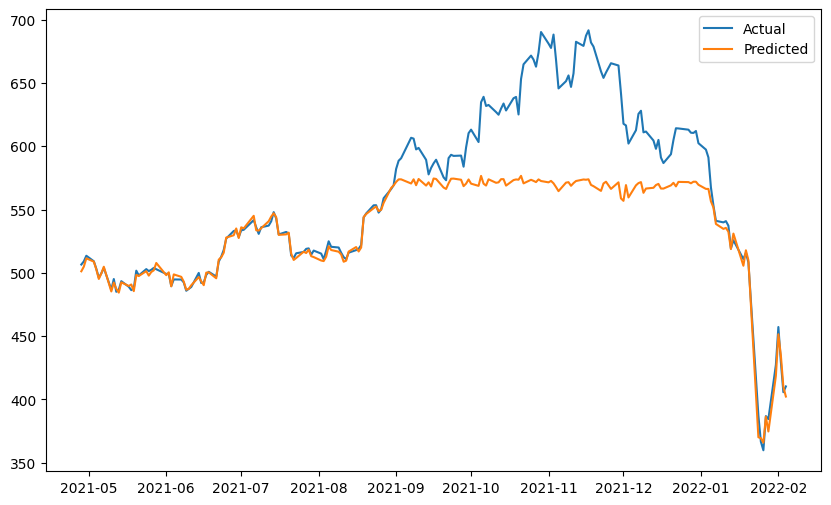

In [113]:
model=GradientBoostingRegressor()
# model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared = False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Accuracy: 0.6209516223656721, MSE: 1859.65061351811, RMSE: 43.12366651292663, MAE: 26.17261588881431


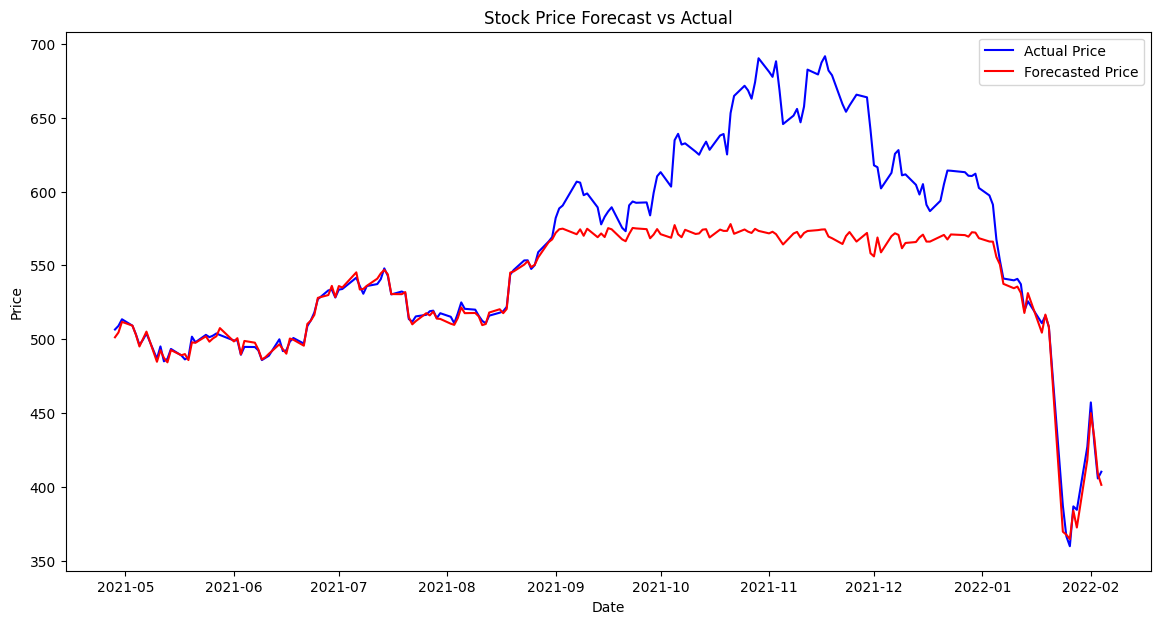

In [114]:
#Hyper Parameter tuning for Gradient Boosting

param_grid = {
    'n_estimators' : [100, 200, 300],
    'learning_rate' : [0.01, 0.05, 0.1],
    'max_depth' : [3, 4, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}')
# print(f'Best Parameters: {grid_search.best_params_}')

# Plot the forecasted versus actual data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='b')
plt.plot(y_test.index, y_pred, label='Forecasted Price', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast vs Actual')
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1009
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -3845.080
Date:                Mon, 27 May 2024   AIC                           7704.159
Time:                        20:07:03   BIC                           7738.569
Sample:                             0   HQIC                          7717.232
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4611      0.182      2.530      0.011       0.104       0.818
ar.L2          0.0404      0.029      1.403      0.161      -0.016       0.097
ar.L3          0.0020      0.034      0.058      0.9

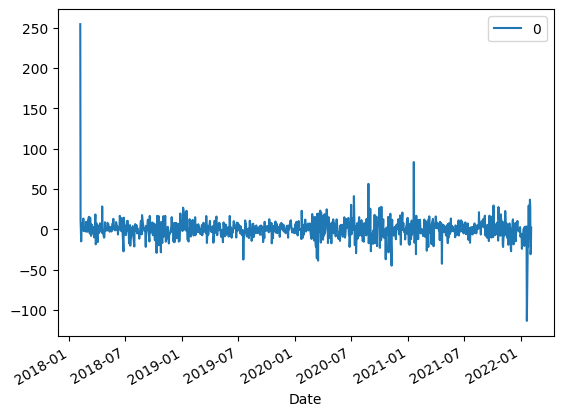

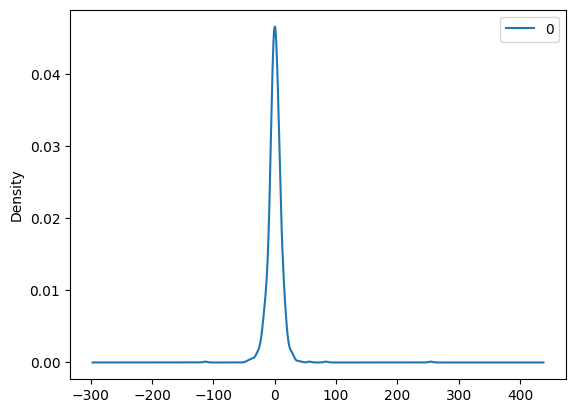

                 0
count  1009.000000
mean      0.427715
std      13.579446
min    -113.173377
25%      -4.844325
50%       0.171699
75%       5.842472
max     254.259995
predicted=473.230110, expected=482.880005
predicted=480.952746, expected=490.649994
predicted=488.632842, expected=493.480011
predicted=495.068469, expected=500.029999
predicted=500.165857, expected=527.510010
predicted=525.394377, expected=503.059998
predicted=506.303430, expected=520.650024
predicted=518.466050, expected=505.869995
predicted=509.563331, expected=534.659973
predicted=527.139510, expected=531.789978
predicted=536.385274, expected=539.440002
predicted=536.331734, expected=539.809998
predicted=543.312400, expected=554.090027
predicted=550.657440, expected=541.450012
predicted=544.445882, expected=541.940002
predicted=540.793250, expected=530.789978
predicted=533.165382, expected=530.719971
predicted=528.132676, expected=525.419983
predicted=526.825405, expected=489.049988
predicted=491.623433, expected=

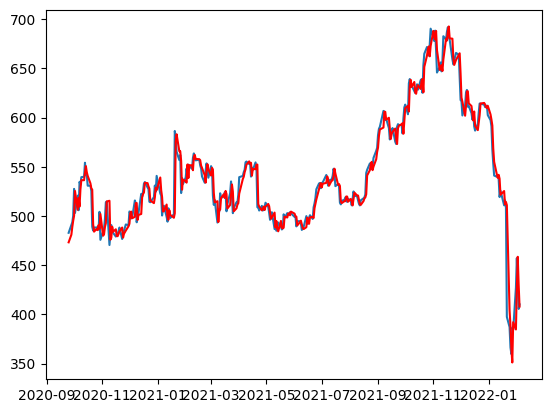

In [115]:
series = pd.read_csv('/content/Netflix Stock.csv', header=0, parse_dates=[0], index_col=0)

# Selecting the 'Close' column as a Series
series = series['Close']

# Fit ARIMA model
model = ARIMA(series, order=(5, 1, 1))
model_fit = model.fit()

# Summary of fit model
print(model_fit.summary())

# Line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

# Summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
accuracy = r2_score(test, predictions)
mse = mean_squared_error(test, predictions, squared=False)
mae = mean_absolute_error(test, predictions)
print(f'Accuracy: {accuracy}, MSE: {mse}, MAE: {mae}')

# plot forecasts against actual outcomes
plt.plot(series[size:len(X)])
plt.plot(pd.Series(predictions, index=series.index[size:len(series)]), color='red')
plt.show()

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mean Squared Error (MSE): 2130.1547143994276
Mean Absolute Error (MAE): 29.48819171857048
R-squared Score: 0.5333893999727474
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}


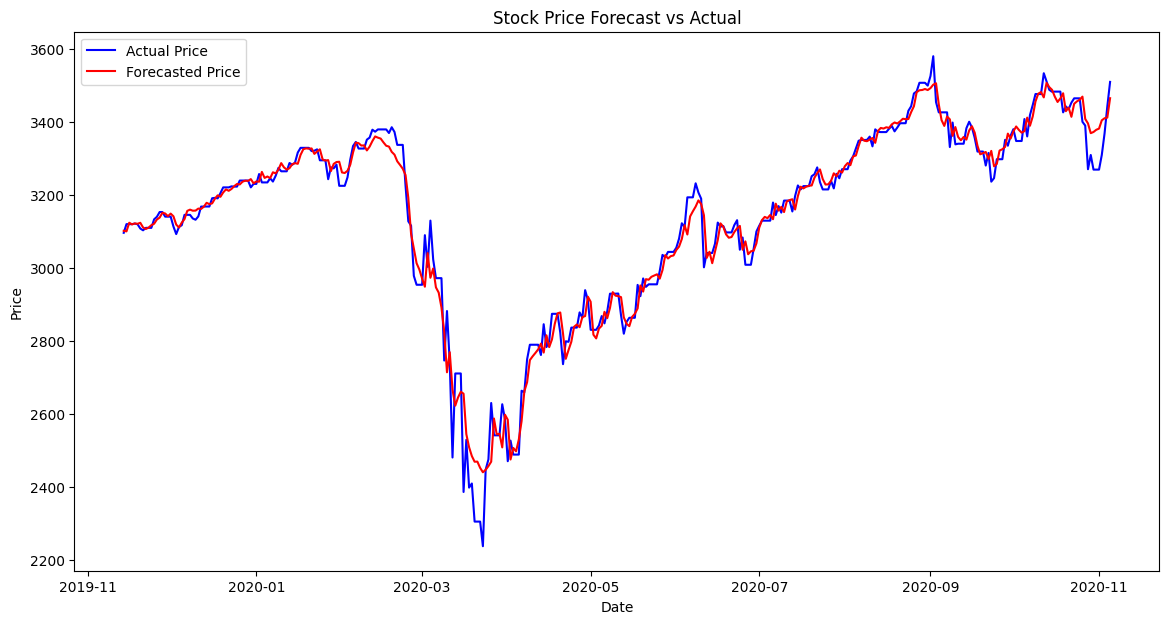

In [116]:
# XGBOOST




# Load your dataset
df = pd.read_csv('//content/Netflix Stock.csv')  # Replace with your data file

# Example preprocessing: Assume 'Date' is your date column and 'Close' is the target
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Decompose the time series to remove trend and seasonality
decomposition = seasonal_decompose(df['Close'], model='additive', period=30)
df['Trend'] = decomposition.trend
df['Seasonal'] = decomposition.seasonal
df['Residual'] = decomposition.resid

# Use residuals as the target for forecasting
df.dropna(inplace=True)  # Drop missing values created by decomposition

# Feature engineering (example: using previous days' residuals as features)
for i in range(1, 6):
    df[f'Lag_{i}'] = df['Residual'].shift(i)

df.dropna(inplace=True)

# Split data into features and target
X = df.drop(columns=['Close', 'Trend', 'Seasonal', 'Residual'])
y = df['Residual']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Reconstruct the predicted stock prices by adding back the trend and seasonal components
trend_test = df.loc[X_test.index, 'Trend']
seasonal_test = df.loc[X_test.index, 'Seasonal']
y_pred_reconstructed = y_pred + trend_test + seasonal_test

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared Score: {r2}')
print(f'Best Parameters: {grid_search.best_params_}')

# Plot the forecasted versus actual data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, df.loc[y_test.index, 'Close'], label='Actual Price', color='b')
plt.plot(y_test.index, y_pred_reconstructed, label='Forecasted Price', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast vs Actual')
plt.legend()
plt.show()



In [1]:
######################################
############## WMA Model #############
######################################

# Assuming df is your DataFrame and it contains 'Date' and 'Close' columns

# Sort by date if not already sorted
df = df.sort_values('Date')

# Define weighted moving average function
def weighted_moving_average(prices, weights):
    return np.dot(prices, weights) / sum(weights)

window_size = 5  # Adjust as needed
weights = np.arange(1, window_size + 1)  # Example weights, adjust as needed

# Compute WMA and add it as a feature
df['WMA'] = df['Close'].rolling(window=window_size).apply(lambda prices: weighted_moving_average(prices, weights), raw=True)
df.dropna(inplace=True)  # Drop rows with NaN values after computing WMA

# Standardize numeric columns
scaler = StandardScaler()
df[['Close', 'WMA']] = scaler.fit_transform(df[['Close', 'WMA']])

# Features and target variable
X = df[['WMA']]  # Features
y = df['Close']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and fit a model (e.g., Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Plotting Predictions vs. Actual
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Close', marker='o')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted Close', marker='x')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()




NameError: name 'df' is not defined